<a href="https://colab.research.google.com/github/0jipy/192kbps_colab_JIPY/blob/main/__TextGen_sRNN%2CLSTM%2CGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRU, LSTM, SimpleRNN 을 이용한 텍스트 생성
 - 데이터 다운로드 : 캐글 New York Times Comments
 - ArticalesApril2018.csv

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from google.colab import files
up = files.upload()

In [ ]:
import pandas as pd
# df = pd.read_csv('ArticlesApril2018.csv', encoding='latin1')
df = pd.read_csv('/content/ArticlesApril2018.csv', encoding='latin1')
df.head()

## 데이터 전처리
     - 헤드라인을 가지고 학습을 시켜서. 문장을 제대로 재생을 하는지 확인해 보자

In [2]:
# 널값확인
df.headline.isnull().sum()

0

In [3]:
# 노이즈 데이터 ('Unknown') 제거
headlines = [line for line in df.headline.values if line != 'Unknown']
len(headlines)

1214

In [4]:
# encoding, 구둣점 제거, 소문자로 변환 => preprocessing
import re
def preprocessing(s):
    s = s.encode('utf8').decode('ascii', 'ignore')
    s = re.sub('[^A-Za-z0-9 ]', '', s)   # re.sub（정규 표현식, 치환 문자, 대상 문자열）
    return s.lower()

In [5]:
headlines = [preprocessing(line) for line in headlines]
headlines[:5]

['former nfl cheerleaders settlement offer 1 and a meeting with goodell',
 'epa to unveil a new rule its effect less science in policymaking',
 'the new noma explained',
 'how a bag of texas dirt  became a times tradition',
 'is school a place for selfexpression']

## Keras 텍스트 전처리

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [7]:
# 단어 집합 생성
t = Tokenizer()
t.fit_on_texts(headlines)
# 단어 집합 크기 - keras Tokenizer의 시작 인덱스가 1이기 때문
vocab_size = len(t.word_index) + 1
vocab_size

3494

In [8]:
sequences = []
for line in headlines:
    encoded=t.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequences.append(encoded[:i+1])
# sequences[:11]

In [9]:
max_len = max(len(seq) for seq in sequences)
max_len

24

In [10]:
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')
# sequences[:3]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          99,  269],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   99,
         269,  371],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   99,  269,
         371, 1115]], dtype=int32)

In [11]:
X = sequences[:,:-1]
y = sequences[:,-1]
Y = to_categorical(y)
X.shape, Y.shape

((7803, 23), (7803, 3494))

## 모델 정의 설정 학습
 - Embedding: 10 차원
 - LSTM: 128 units

### LSTM

In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [ ]:
# 임베딩 벡터 10차원, LSTM 노드 크기 128
model = Sequential([ 
    Embedding(vocab_size, 10, input_length=max_len-1),
    LSTM(128),
    Dense(vocab_size, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 10)            34940     
                                                                 
 lstm (LSTM)                 (None, 128)               71168     
                                                                 
 dense (Dense)               (None, 3494)              450726    
                                                                 
Total params: 556,834
Trainable params: 556,834
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 컴파일
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Colab, GPU 환경
%time hist = model.fit(X, Y, epochs=200, verbose=1)

In [ ]:
hist.history['accuracy'][-1]

0.9168268442153931

- 모델 검증   
vocap size 3944개인데 에서 10차원으로 줄여도 성능이 꽤 괞찮아

In [ ]:
up = files.upload()

In [ ]:
from my_util import sentence_generation

In [ ]:
print(sentence_generation(model, t, max_len, 'former', 10))
print(sentence_generation(model, t, max_len, 'epa', 10))
print(sentence_generation(model, t, max_len, 'how', 10))

former judge to review files seized in searches war bereaved on
epa chiefs ethics woes have echoes in his past in fix
how to make a crossword puzzle with with rights has the


- 훈련과정 시각화

In [ ]:
y_acc = hist.history['accuracy']
y_loss = hist.history['loss']
xs = np.arange(1, len(y_acc)+1)

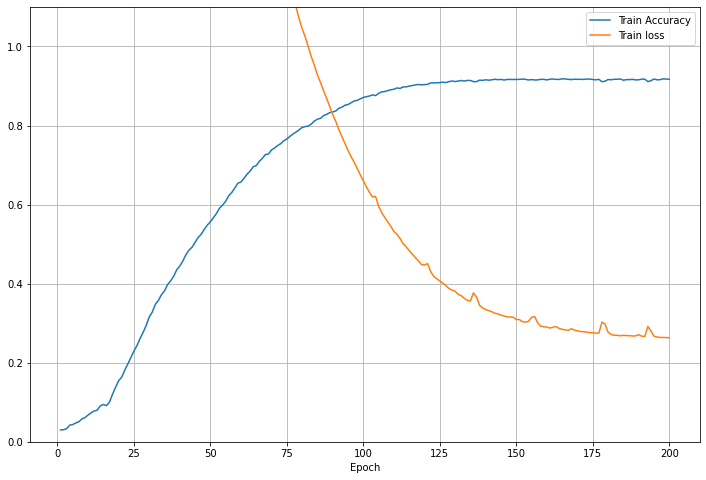

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='Train Accuracy')
plt.plot(xs, y_loss, label='Train loss')
plt.legend(), plt.grid(), 
plt.ylim(0,1.1)
plt.xlabel('Epoch')
plt.show()

### model_GRU
-  GRU_ 임베딩 10차원, 노드 크기 128

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense #

In [ ]:
model_GRU = Sequential([ 
    Embedding(vocab_size, 10, input_length=max_len-1),
    GRU(128),
    Dense(vocab_size, activation='softmax')
])
model_GRU.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 10)            34940     
                                                                 
 lstm (LSTM)                 (None, 128)               71168     
                                                                 
 dense (Dense)               (None, 3494)              450726    
                                                                 
Total params: 556,834
Trainable params: 556,834
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 컴파일
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Colab, GPU 환경
%time hist = model.fit(X, Y, epochs=200)

In [ ]:
hist.history['accuracy'][-1]

0.9168268442153931

### SimpleRNN
Embedding: 10 차원
SimpleRNN: 128 units

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

In [14]:
# Embedding=10, SimpleRNN=128
model_RNN = Sequential([ 
    Embedding(vocab_size, 10, input_length=max_len-1),
    SimpleRNN(128),
    Dense(vocab_size, activation='softmax')
])
model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 10)            34940     
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               17792     
                                                                 
 dense (Dense)               (None, 3494)              450726    
                                                                 
Total params: 503,458
Trainable params: 503,458
Non-trainable params: 0
_________________________________________________________________


In [16]:
model_RNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
%time hist = model_RNN.fit(X, Y, epochs=200, verbose=0)

CPU times: user 41min 43s, sys: 7min 32s, total: 49min 15s
Wall time: 19min 12s


In [18]:
hist.history['accuracy'][-1]

0.9147763848304749

In [19]:
y_acc = hist.history['accuracy']
y_loss = hist.history['loss']
xs = np.arange(1, len(y_acc)+1)

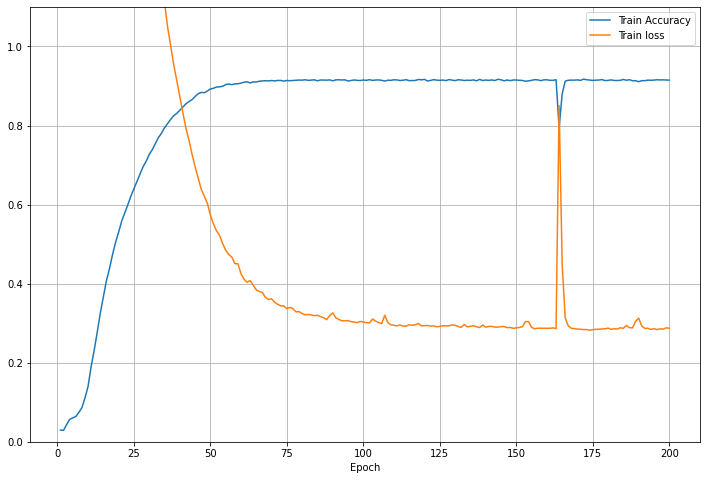

In [22]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='Train Accuracy')
plt.plot(xs, y_loss, label='Train loss')
plt.legend(), plt.grid(), 
plt.ylim(0,1.1)
plt.xlabel('Epoch')
plt.show()
# 50번 이후로는 그다지 좋아지지 않았다. 
# 시간을 고려하여 100번 이하로 학습수행할것.

### SImpleRNN model two
- Embedding=4, SimpleRNN=128  
- 학습은 100번만, epochs = 100
- 가장 중요하다고 생각되는 임베딩의 차원을 4차원으로 낮춰본다
- 여기까지 하고 모델 검증으로 헤드라인을 알맞게 만들어내는지 볼것.


In [23]:
# Embedding=4, SimpleRNN=128
model_RNN_e4 = Sequential([ 
    Embedding(vocab_size, 4, input_length=max_len-1),
    SimpleRNN(128),
    Dense(vocab_size, activation='softmax')
])
model_RNN_e4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 23, 4)             13976     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               17024     
                                                                 
 dense_1 (Dense)             (None, 3494)              450726    
                                                                 
Total params: 481,726
Trainable params: 481,726
Non-trainable params: 0
_________________________________________________________________


In [24]:
model_RNN_e4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
%time hist = model_RNN_e4.fit(X, Y, epochs=100, verbose=0)

Epoch 1/100
244/244 [==============================] - 7s 26ms/step - loss: 7.6611 - accuracy: 0.0293
Epoch 2/100
244/244 [==============================] - 6s 26ms/step - loss: 7.1392 - accuracy: 0.0302
Epoch 3/100
244/244 [==============================] - 6s 26ms/step - loss: 6.9839 - accuracy: 0.0406
Epoch 4/100
244/244 [==============================] - 6s 26ms/step - loss: 6.7601 - accuracy: 0.0495
Epoch 5/100
244/244 [==============================] - 6s 26ms/step - loss: 6.4648 - accuracy: 0.0560
Epoch 6/100
244/244 [==============================] - 6s 26ms/step - loss: 6.1549 - accuracy: 0.0598
Epoch 7/100
244/244 [==============================] - 6s 26ms/step - loss: 5.8565 - accuracy: 0.0634
Epoch 8/100
244/244 [==============================] - 6s 26ms/step - loss: 5.5648 - accuracy: 0.0725
Epoch 9/100
244/244 [==============================] - 6s 26ms/step - loss: 5.2887 - accuracy: 0.0838
Epoch 10/100
244/244 [==============================] - 6s 26ms/step - loss: 5.025

In [ ]:
hist.history['accuracy'][-1]

0.9147763848304749